# Load Dataset and Libraries

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bellayoon","key":"45201df0e0329601dbdcfa4dd7aa68ef"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download 'ninadaithal/imagesoasis'

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
 99% 1.22G/1.23G [00:06<00:00, 247MB/s]
100% 1.23G/1.23G [00:06<00:00, 197MB/s]


In [4]:
import pandas as pd
import numpy as np
from numpy import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import albumentations as A
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from PIL import Image

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
!unzip imagesoasis.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_114.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_115.jpg  
  inflating

In [6]:
path1, path2, path3, path4 = [], [], [], []

for dirname, _, filenames in os.walk('/content/Data/Non Demented'):
    for filename in filenames:
        path1.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/Data/Mild Dementia'):
    for filename in filenames:
        path2.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/Data/Moderate Dementia'):
    for filename in filenames:
        path3.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/Data/Very mild Dementia'):
    for filename in filenames:
        path4.append(os.path.join(dirname, filename))


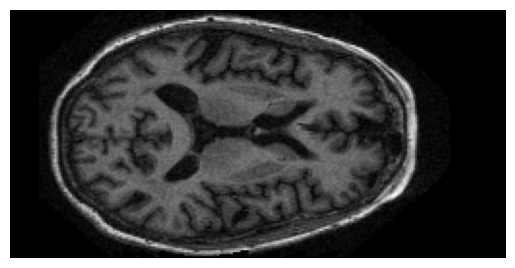

In [7]:
img = plt.imread(path3[43])
plt.imshow(img)
plt.axis('off')
plt.show()

 Define Image Size and Preprocessing Functions

In [8]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [9]:
SIZE = 256  # Define the size to which images will be resized

def preprocess_images(paths, size=SIZE):
    images = []
    for path in tqdm(paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = cv2.resize(img, (size, size))         # Resize image
        img = img.astype('float32') / 255.0         # Normalize to [0, 1]
        images.append(img_to_array(img))
    return np.array(images)

# Load high-resolution images from one class for illustration
high_res_images = preprocess_images(path3)  # Replace path3 with the desired class path


100%|██████████| 488/488 [00:00<00:00, 622.91it/s]


Create Low-Resolution Images by Downsampling

In [10]:
def downsample_images(images, scale=2):
    low_res_images = []
    for img in images:
        # Downsample the image by the scale factor
        low_res = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale))
        # Upsample back to the original size to simulate low-res appearance
        low_res = cv2.resize(low_res, (img.shape[1], img.shape[0]))
        low_res_images.append(low_res)
    return np.array(low_res_images)

low_res_images = downsample_images(high_res_images, scale=2)


Visualize High- and Low-Resolution Images

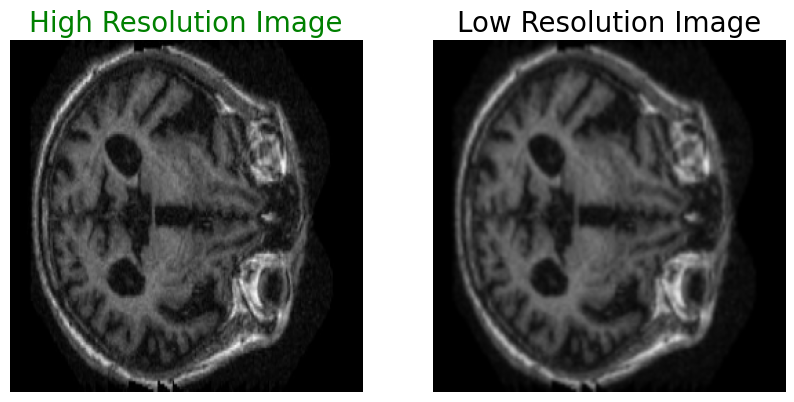

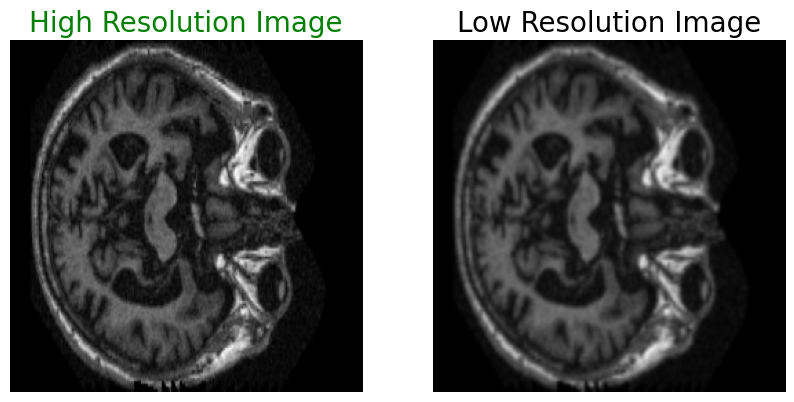

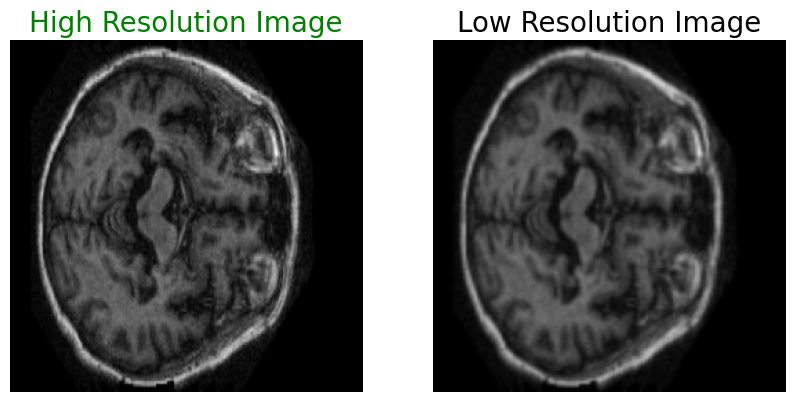

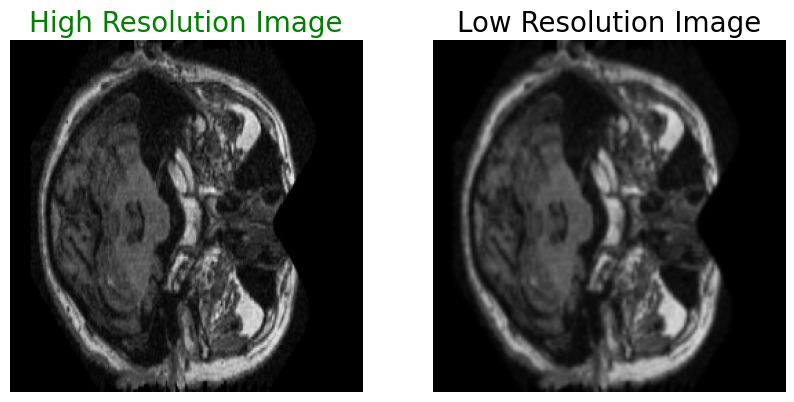

In [11]:
for i in range(4):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('High Resolution Image', color='green', fontsize=20)
    plt.imshow(high_res_images[i])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Low Resolution Image', color='black', fontsize=20)
    plt.imshow(low_res_images[i])
    plt.axis('off')
    plt.show()


Model Preparation for Super-Resolution (CNN-based)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D

def build_sr_cnn_model(input_shape=(SIZE, SIZE, 3)):
    model = Sequential()
    model.add(Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(3, (5, 5), activation='sigmoid', padding='same'))
    return model

sr_model = build_sr_cnn_model()
sr_model.compile(optimizer='adam', loss='mse')
sr_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 3)         │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [13]:
# Assuming high_res_images are the targets and low_res_images are the inputs
history = sr_model.fit(low_res_images, high_res_images, epochs=50, batch_size=16, validation_split=0.1)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 0.1278 - val_loss: 0.0707
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0435 - val_loss: 0.0041
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 9.9192e-04
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.6871e-04 - val_loss: 8.8273e-04
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.1865e-04 - val_loss: 8.3869e-04
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.8282e-04 - val_loss: 8.7849e-04
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━

Image Quality Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


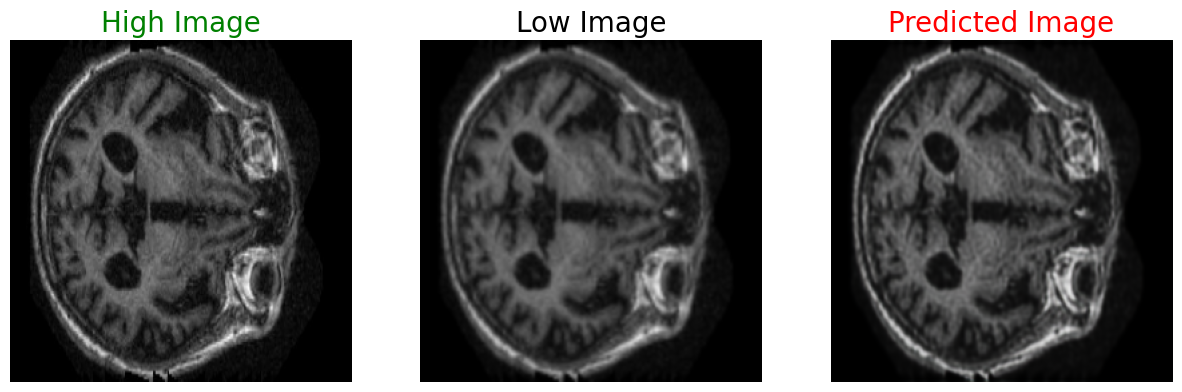

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


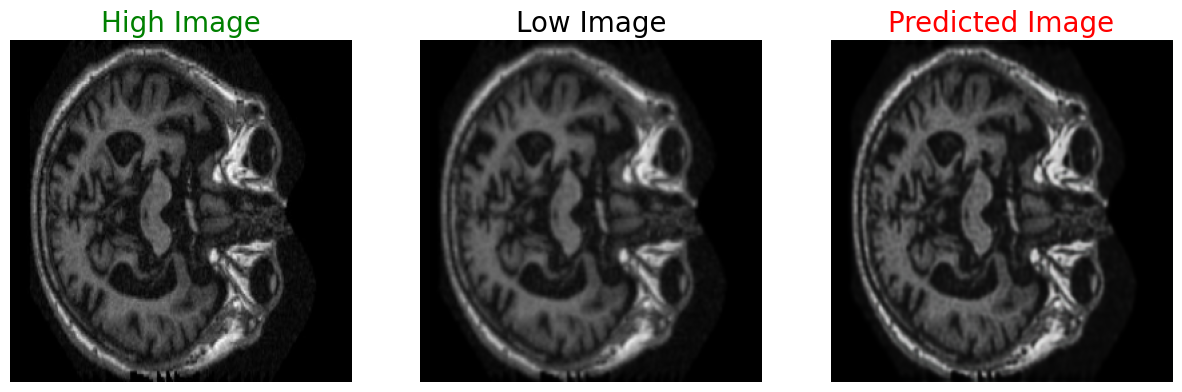

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


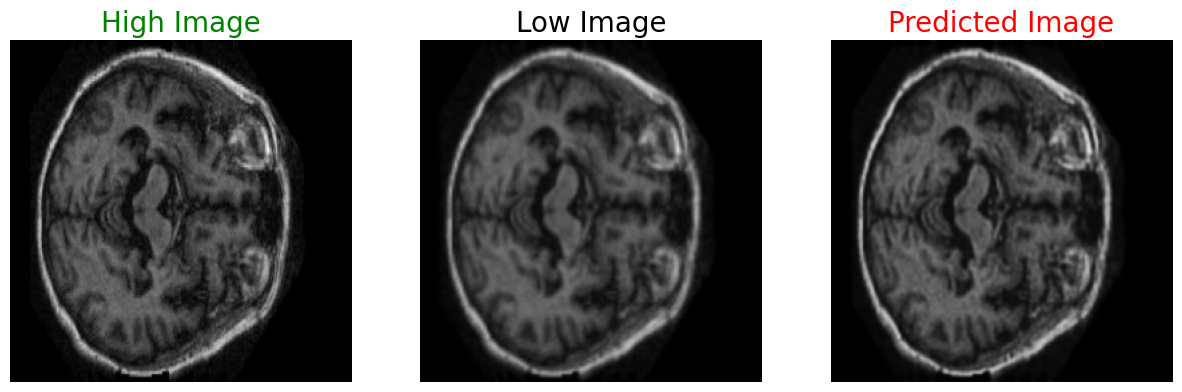

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


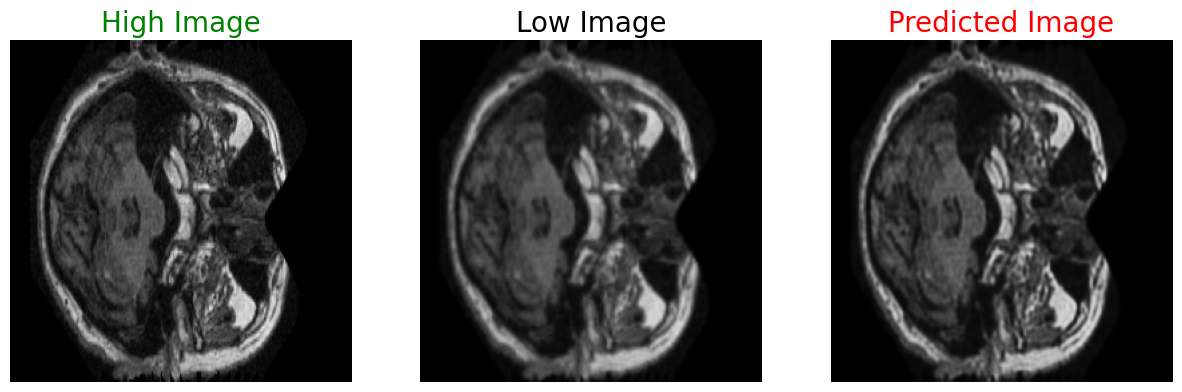

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


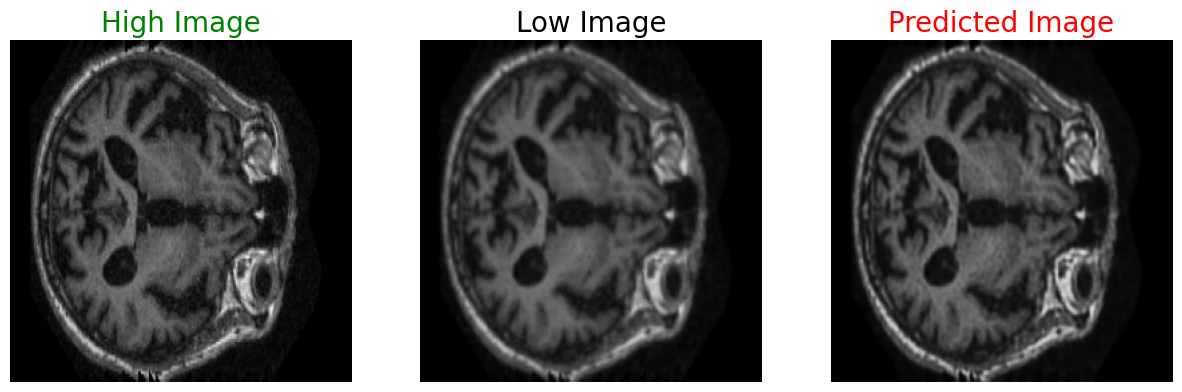

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


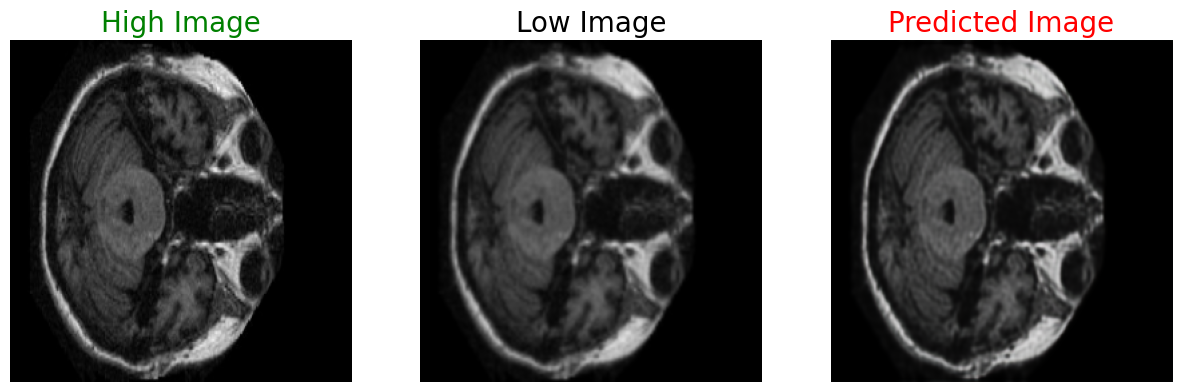

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


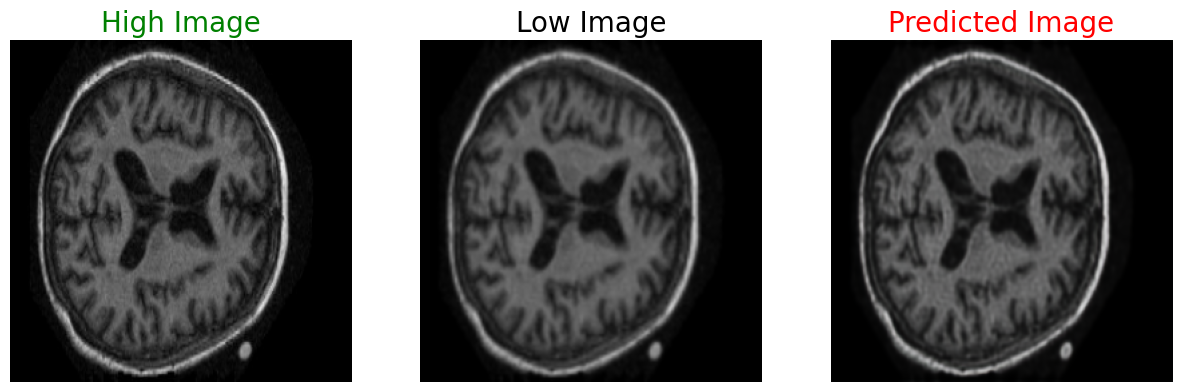

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


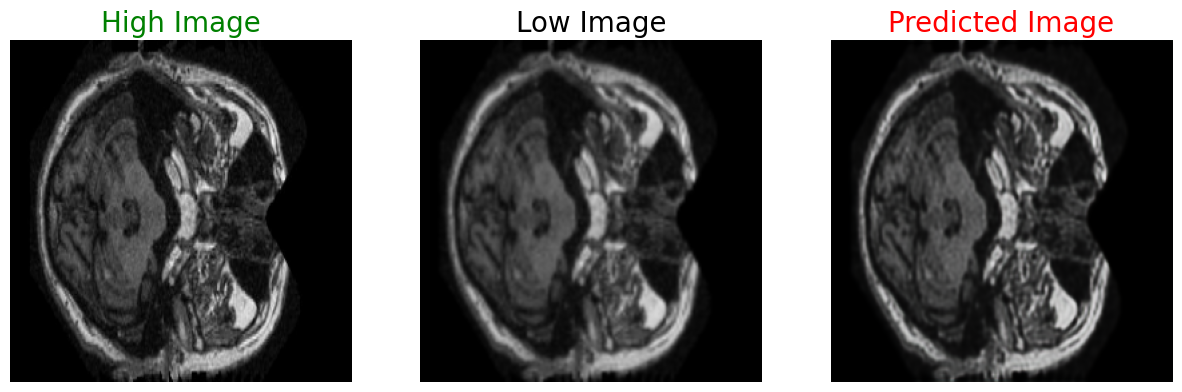

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


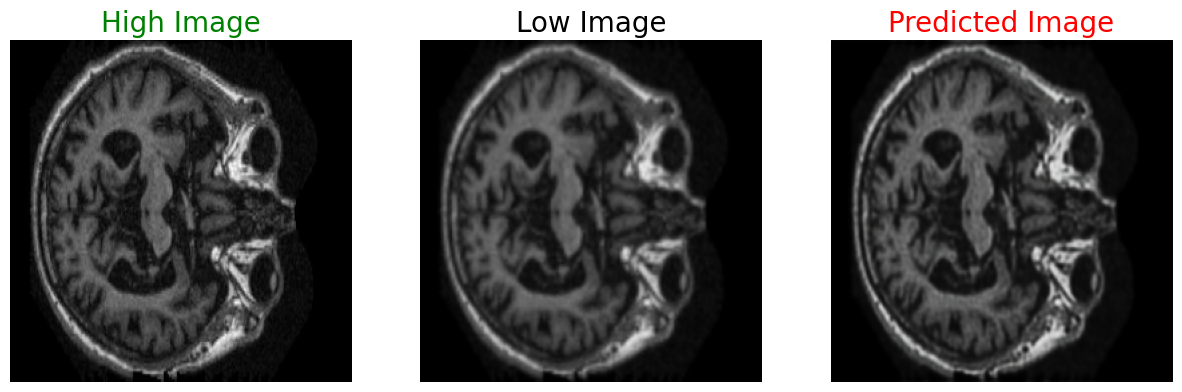

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


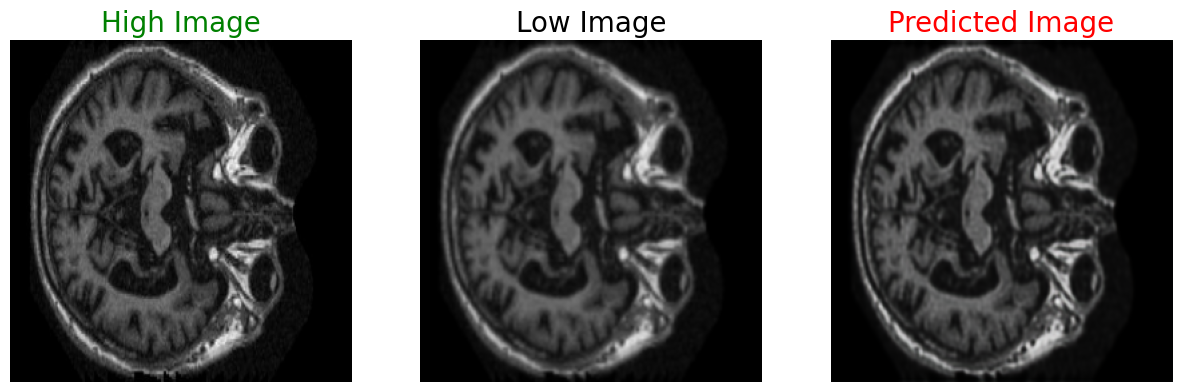

In [16]:

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(high)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(low)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Image', color='red', fontsize=20)
    plt.imshow(predicted)
    plt.axis('off')

    plt.show()

for i in range(10):  # Adjust the range based on the number of test images
    predicted = np.clip(sr_model.predict(np.expand_dims(low_res_images[i], axis=0))[0], 0.0, 1.0)
    plot_images(high_res_images[i], low_res_images[i], predicted)


Visualization (1) Sample Images from Each Class

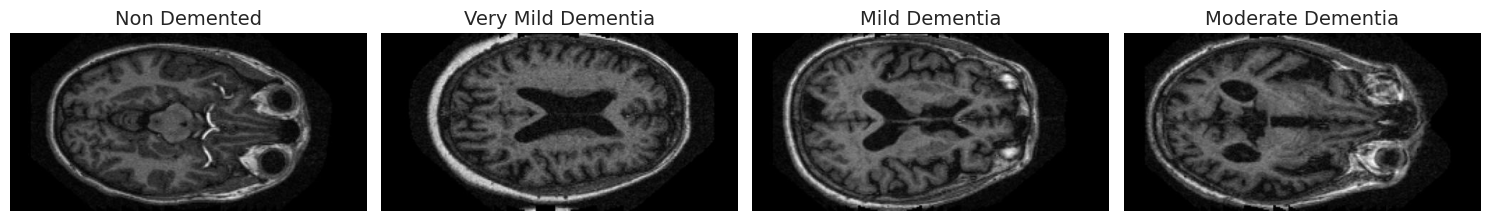

In [17]:
classes = ["Non Demented", "Very Mild Dementia", "Mild Dementia", "Moderate Dementia"]
paths = [path1, path4, path2, path3]

plt.figure(figsize=(15, 10))
for i, class_path in enumerate(paths):
    img = plt.imread(class_path[0])  # Display the first image from each class
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(classes[i], fontsize=14)
    plt.axis('off')
plt.tight_layout()
plt.show()


Visualization (2) Before and After Downsampling

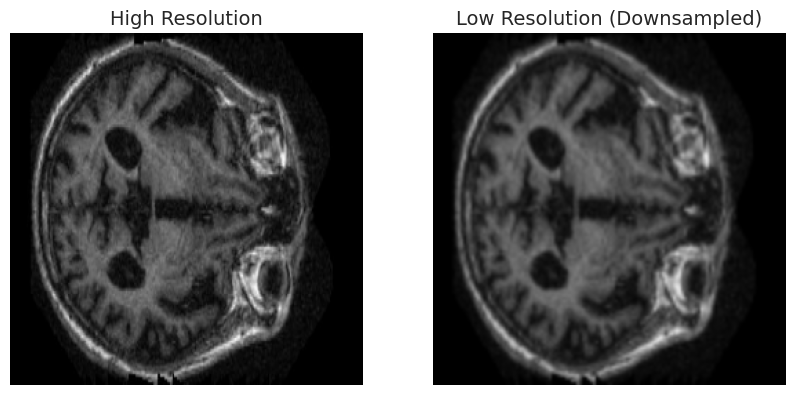

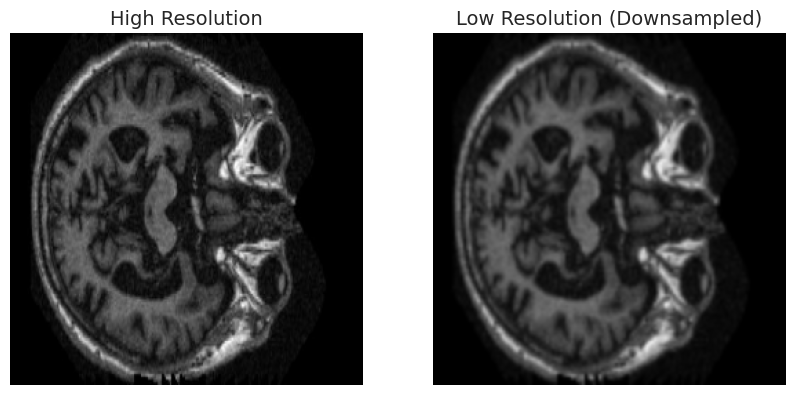

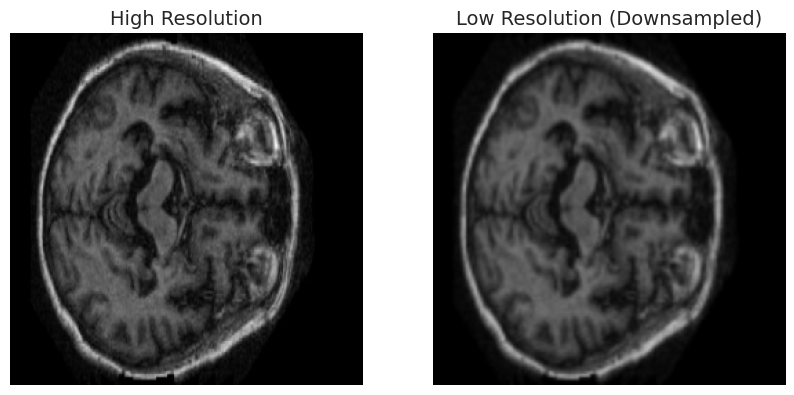

In [18]:
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('High Resolution', fontsize=14)
    plt.imshow(high_res_images[i])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Low Resolution (Downsampled)', fontsize=14)
    plt.imshow(low_res_images[i])
    plt.axis('off')
    plt.show()


Visualization (3) Enhanced vs. Low-Resolution Images (Model Output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


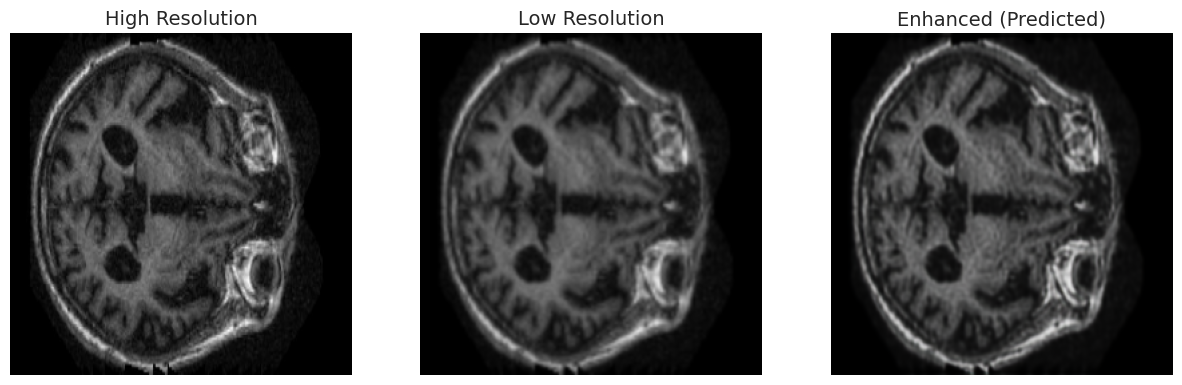

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


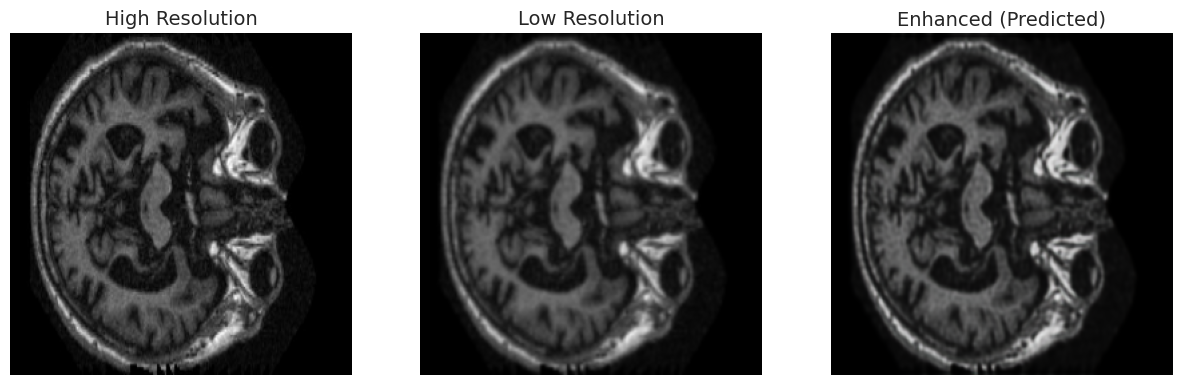

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


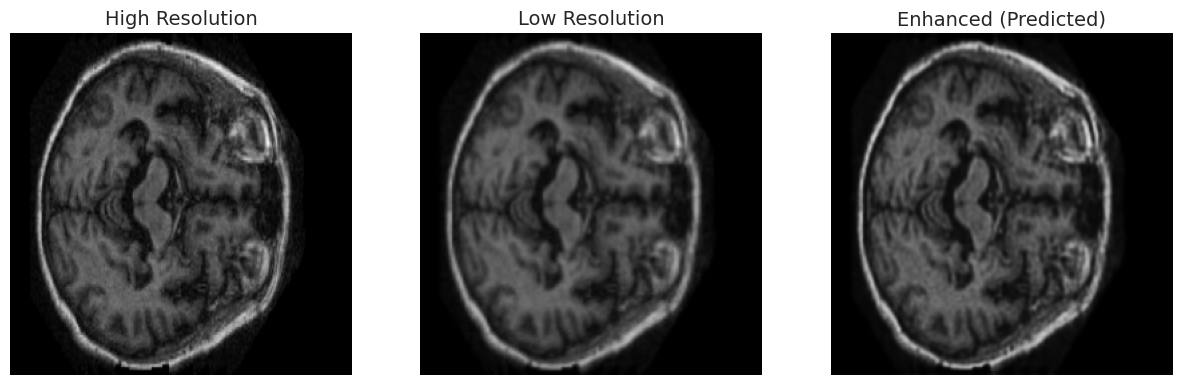

In [19]:
for i in range(3):
    predicted = np.clip(sr_model.predict(np.expand_dims(low_res_images[i], axis=0))[0], 0.0, 1.0)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('High Resolution', fontsize=14)
    plt.imshow(high_res_images[i])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Low Resolution', fontsize=14)
    plt.imshow(low_res_images[i])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Enhanced (Predicted)', fontsize=14)
    plt.imshow(predicted)
    plt.axis('off')
    plt.show()


Visualization (4) Metric Comparison Across Images -  PSNR and SSIM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


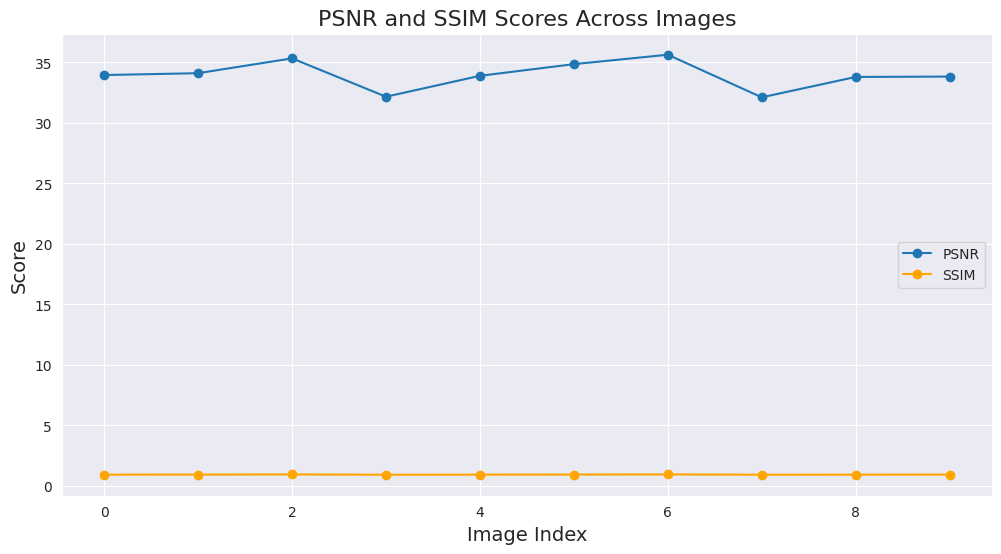

In [20]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

psnr_scores = []
ssim_scores = []

for i in range(10):
    predicted = np.clip(sr_model.predict(np.expand_dims(low_res_images[i], axis=0))[0], 0.0, 1.0)
    psnr_scores.append(psnr(high_res_images[i], predicted, data_range=1.0))  # PSNR with specified data_range
    ssim_scores.append(ssim(high_res_images[i], predicted, win_size=5, channel_axis=-1, data_range=1.0))  # SSIM with data_range

plt.figure(figsize=(12, 6))
plt.plot(psnr_scores, label='PSNR', marker='o')
plt.plot(ssim_scores, label='SSIM', marker='o', color='orange')
plt.title('PSNR and SSIM Scores Across Images', fontsize=16)
plt.xlabel('Image Index', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend()
plt.show()


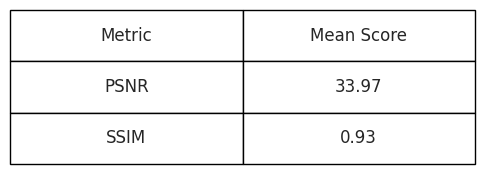

In [33]:
mean_psnr = np.mean(psnr_scores)
mean_ssim = np.mean(ssim_scores)
plt.figure(figsize=(6, 2))
table_data = [['Metric', 'Mean Score'], ['PSNR', f"{mean_psnr:.2f}"], ['SSIM', f"{mean_ssim:.2f}"]]
table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.axis('off')

plt.show()
